In [4]:
#Import pycaret
from pycaret.classification import *
import pandas as pd

In [5]:
df=pd.read_csv('Data.csv')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681456 entries, 0 to 681455
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   PRODUCT_CODE                659606 non-null  object 
 1   DOC                         681456 non-null  object 
 2   EXPIRY_DATE                 681456 non-null  object 
 3   PRODUCT_TYPE                681456 non-null  object 
 4   TERMINATION_EFFECTIVE_DATE  623016 non-null  object 
 5   TERM                        681456 non-null  int64  
 6   PREMIUM_AMOUNT              681395 non-null  float64
 7   SA                          681456 non-null  float64
 8   STATUS_NAME                 681456 non-null  object 
 9   PREMIUM_STATUS              681456 non-null  object 
 10  PREMIUM_FREQUENCY           681456 non-null  object 
 11  MODE_NAME                   681456 non-null  object 
 12  GENDER                      681456 non-null  object 
 13  MARITAL_STATUS

In [8]:
#remove date collumns
# convert the 'Date' column to datetime format
df['TERMINATION_EFFECTIVE_DATE']= pd.to_datetime(df['TERMINATION_EFFECTIVE_DATE'])
df['BIRTHDAY']= pd.to_datetime(df['BIRTHDAY'])
df['DOC']= pd.to_datetime(df['DOC'])


#Etract the age from  birth year
#soucrce: https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
from datetime import date

def calculate_age(born):
    #today = date.today()
    twenty20 = date(2020, 12, 30)
    return twenty20.year - born.year - ((twenty20.month, twenty20.day) < (born.month, born.day))




#Calculate the policy age

df['Policy_Age'] = df['DOC'].apply(calculate_age)
df['Policy_holder_Age'] = df['BIRTHDAY'].apply(calculate_age)

df = df[df.columns.difference(['DOC', 'BIRTHDAY','TERMINATION_EFFECTIVE_DATE','EXPIRY_DATE'])]


In [9]:
df.head()

AGENT_PERSISTENCY  CLAWBACK_COMMISSION EDUCATION GENDER    INCOME  \
0              86.41          -114.769811    Others      M  111600.0   
1              90.25           -83.140400    Others      F   60396.0   
2               0.00             0.000000    Others      M   48108.0   
3              86.62          -105.602085    Others      M   24000.0   
4              82.86           -30.271900    Others      M   55632.0   

  MARITAL_STATUS        MODE_NAME  PREMIUM_AMOUNT PREMIUM_FREQUENCY  \
0         Single              GSO          302.39           Monthly   
1         Single              DDE          307.74           Monthly   
2        Married              GSO          276.58           Monthly   
3         Single             Cash          207.73           Monthly   
4        Married  ESO(Electronic)          198.43           Monthly   

  PREMIUM_STATUS PRODUCT_CODE PRODUCT_TYPE  Policy_Age  Policy_holder_Age  \
0        Regular       BMFW-1         Risk          12                 55   
1        Regular       BMFW-1         Risk          14                 47   
2        Regular       BMFW-1         Risk          14                 65   
3        Regular       BMFW-1         Risk          11                 42   
4        Regular       BMFW-1         Risk          13                 55   

          SA SALES_CHANNEL STATUS_NAME  TERM TERMINATION_REASON  
0  13439.160          Tied  Terminated  7991          FINANCIAL  
1  22689.950        Broker      Lapsed  7992                NaN  
2  15938.480          Tied  Terminated  7992          FINANCIAL  
3  11940.525          Tied      Lapsed  7990                NaN  
4  12298.740        Broker  Terminated  7992          FINANCIAL

In [10]:
#Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df.head()


AGENT_PERSISTENCY  CLAWBACK_COMMISSION EDUCATION GENDER    INCOME  \
0               0.00                  NaN       NaN      F       NaN   
1              98.19          -875.431333    Others      F   90264.0   
2               0.00                  NaN       NaN      M       NaN   
3              78.55                  NaN    Others      F  179136.0   
4               0.00           -91.930264    Others      M   19632.0   

  MARITAL_STATUS                   MODE_NAME  PREMIUM_AMOUNT  \
0            NaN  Electronic Cash Collection           60.00   
1         Single                         GSO          373.03   
2            NaN  Electronic Cash Collection           50.00   
3         Single                         GSO          325.00   
4         Single                         GSO          226.09   

  PREMIUM_FREQUENCY PREMIUM_STATUS PRODUCT_CODE PRODUCT_TYPE  Policy_Age  \
0           Monthly        Regular       MOSK-1         Risk           0   
1           Monthly        Regular       BMFW-1         Risk           7   
2           Monthly        Regular       MOSK-1         Risk           5   
3           Monthly        Regular       MFDS-1   Investment           1   
4           Monthly        Regular       BMFW-1         Risk          11   

   Policy_holder_Age         SA SALES_CHANNEL STATUS_NAME  TERM  \
0                 26   4000.000          Tied     Inforce  7979   
1                 51  23881.045        Broker  Terminated  7986   
2                 51   4000.000          Tied      Lapsed  7983   
3                 36      0.000          Tied     Inforce    14   
4                 40  17389.115        Broker  Terminated  7990   

  TERMINATION_REASON  
0                NaN  
1          FINANCIAL  
2                NaN  
3                NaN  
4          FINANCIAL

In [12]:
#Dropt 'Termination reason collumn as it gives away the class'
df.drop(df[df['STATUS_NAME'] == 'Waiting for Validate'].index, inplace = True)

In [13]:
df.shape

(681450, 19)

In [14]:
#Check if the waiting for validate has been removed
df.STATUS_NAME.unique()

array(['Inforce', 'Terminated', 'Lapsed'], dtype=object)

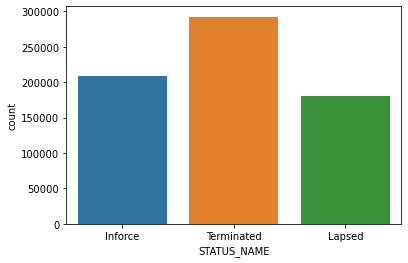

In [15]:
#Simple count plot for class balance inestigation
import seaborn as sns
ax = sns.countplot(x="STATUS_NAME", data=df)

The above plot shows more policies have been terminated foe the data 2014 to 2020.

Data set currently seats at 600k rows. This might be too expensive for computation.
Maybe sampling the data would help reduce that.


In [20]:
#random sample
df2=df.sample(n=10000,replace="False")
df2.shape

(10000, 19)

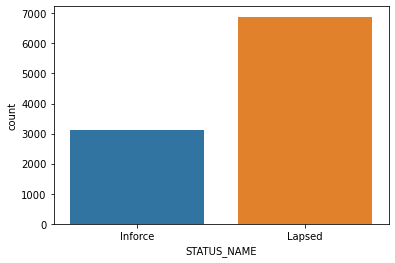

In [87]:
#Check class balance of the sample
#Simple count plot for class balance inestigation
import seaborn as sns
ax = sns.countplot(x="STATUS_NAME", data=df2)

In [22]:
#drop the termination reason
df2=df2.drop(['TERMINATION_REASON'], axis=1)

In [86]:
#Assume Terminated=Lapsed
df2['STATUS_NAME'] = df2['STATUS_NAME'].str.replace('Terminated','Lapsed')

Seems reasonable to proceed.

In [88]:
#Set up an experiement
exp=setup(df2,target='STATUS_NAME',train_size=0.7,
          imputation_type='simple',
          numeric_imputation='mean',categorical_imputation='mode',
          fix_imbalance=True,
          normalize=True ,  #Rescaling
          transformation= True,
          feature_interaction=True,
          feature_ratio= True,
          #polynomial_degree=2,
          #polynomial_features=True,
          #trigonometry_features=True,
          bin_numeric_features=['Policy_holder_Age','INCOME']
         
         
         
         
         
         )

In [78]:
data_feature_engginerring=get_config('X')

In [81]:
data_feature_engginerring

AGENT_PERSISTENCY  CLAWBACK_COMMISSION  PREMIUM_AMOUNT  Policy_Age  \
330150           0.748170            -0.321865        0.885808   -0.407117   
73422            0.710205            -0.321865        0.713067   -0.407117   
539824          -1.244109            -0.321865       -1.173026    0.283714   
113904           1.547560             1.861583       -0.101152    1.513652   
447860           0.607987             1.840690        0.096024    1.513652   
...                   ...                  ...             ...         ...   
397019          -1.244109            -0.321865       -0.979723    0.537894   
32067            0.682263            -0.321865        0.348139    1.885018   
239478           1.295246             1.857877        0.678589    1.067959   
496929           0.584939            -2.338489        1.585846   -1.352081   
442111          -1.244109            -0.321865       -1.089632    2.321608   

              SA      TERM  EDUCATION_Unknown  GENDER_F  GENDER_M  GENDER_N  \
330150  0.514120  0.948332                0.0       0.0       1.0       0.0   
73422   0.739619  0.948332                0.0       0.0       1.0       0.0   
539824 -0.427151  0.948927                0.0       0.0       0.0       1.0   
113904  0.645085  0.951310                0.0       1.0       0.0       0.0   
447860 -0.794349 -1.056252                0.0       1.0       0.0       0.0   
...          ...       ...                ...       ...       ...       ...   
397019 -0.427151  0.949225                0.0       0.0       0.0       1.0   
32067  -0.794349 -1.055408                0.0       0.0       1.0       0.0   
239478 -0.794349 -1.056252                1.0       0.0       1.0       0.0   
496929 -0.794349 -1.050765                0.0       0.0       1.0       0.0   
442111  0.167975 -1.053087                0.0       0.0       1.0       0.0   

        ...  CLAWBACK_COMMISSION_divide_Policy_Age  \
330150  ...                               0.790596   
73422   ...                               0.790596   
539824  ...                              -1.134469   
113904  ...                               1.229862   
447860  ...                               1.216059   
...     ...                                    ...   
397019  ...                              -0.598381   
32067   ...                              -0.170749   
239478  ...                               1.739652   
496929  ...                               1.729548   
442111  ...                              -0.138639   

        TERM_divide_AGENT_PERSISTENCY  SA_divide_TERM  \
330150                       1.267535        0.542131   
73422                        1.335292        0.779916   
539824                      -0.762736       -0.450141   
113904                       0.614716        0.678102   
447860                      -1.737293        0.752045   
...                               ...             ...   
397019                      -0.762976       -0.450000   
32067                       -1.546922        0.752647   
239478                      -0.815484        0.752045   
496929                      -1.796366        0.755972   
442111                       0.846459       -0.159507   

        PRODUCT_CODE_BMFW-1_multiply_AGENT_PERSISTENCY  \
330150                                        0.748170   
73422                                         0.710205   
539824                                       -0.000000   
113904                                        1.547560   
447860                                        0.000000   
...                                                ...   
397019                                       -1.244109   
32067                                         0.000000   
239478                                        0.000000   
496929                                        0.000000   
442111                                       -0.000000   

        CLAWBACK_COMMISSION_multiply_AGENT_PERSISTENCY  \
330150                           

In [70]:
#get the pipeline
pipeline=get_config('prep_pipe')
pipeline

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='STATUS_NAME', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_s...
                ('fix_perfect', Remove_100(target='STATUS_NAME')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs',
                 DFS_Classic(interactions=['multiply', 'divi

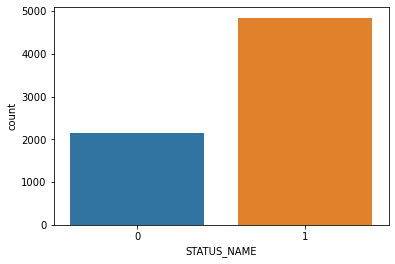

In [89]:
Target=get_config('y_train')
ax = sns.countplot(Target)


Note that there are about 50 parameters we can tune here as pre-processing step prior to modelling

In [90]:
# return best model
Models = compare_models()

# Notes
Normalisation did not improve tree based methods but improved the svm method.

Transformation of the data improved LDA

Feature interaction and feature ratio did not improve the tree based methods significantly but it improved naive bayes accuracy
and other methods such as ridge

Polynomial features at degree 2 impored accuracy of the LDA FURTHER,NAIVE BAYES

In [91]:
#Create a model
gbc=create_model('gbc')

In [92]:
#Model object
gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4443, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [100]:
X_train=get_config('X_train')

In [101]:
X_test=get_config('X_test')

In [110]:
y_test=get_config('y_test')
y_test.iloc[1]

0

In [108]:
X_test

AGENT_PERSISTENCY  CLAWBACK_COMMISSION  PREMIUM_AMOUNT  Policy_Age  \
336896          -1.239616            -0.330674       -0.948154   -0.407913   
115478           1.258319            -0.330674        1.270781   -1.907991   
625917           1.062969            -0.330674        1.339623   -0.407913   
83026           -1.239616            -0.330674       -0.947333   -0.034096   
23081           -1.239616            -0.330674       -0.312681    0.278420   
...                   ...                  ...             ...         ...   
498491           0.830891            -0.330674        1.445950   -0.844176   
280985          -0.198202            -0.330674        0.473552   -0.844176   
148742          -1.239616            -0.330674       -1.072313    0.278420   
58518            1.142410            -0.330674       -0.922838   -1.907991   
181954          -1.239616            -0.330674       -1.201544   -1.343897   

              SA      TERM  EDUCATION_Others  GENDER_F  GENDER_M  GENDER_N  \
336896 -0.423370  0.943729               1.0       1.0       0.0       0.0   
115478 -0.787073 -1.058633               1.0       1.0       0.0       0.0   
625917  3.182656 -1.057180               1.0       1.0       0.0       0.0   
83026   0.063083  0.944031               1.0       0.0       1.0       0.0   
23081  -0.423370  0.944334               1.0       0.0       0.0       1.0   
...          ...       ...               ...       ...       ...       ...   
498491  2.131419  0.943426               1.0       1.0       0.0       0.0   
280985 -0.787073 -1.059048               1.0       0.0       1.0       0.0   
148742  0.063083  0.944334               1.0       1.0       0.0       0.0   
58518   1.265666  0.942821               1.0       0.0       1.0       0.0   
181954 -0.423370  0.943124               1.0       1.0       0.0       0.0   

        ...  SA_divide_TERM  CLAWBACK_COMMISSION_multiply_AGENT_PERSISTENCY  \
336896  ...       -0.448614                                        0.409908   
115478  ...        0.743480                                       -0.416093   
625917  ...       -3.010515                                       -0.351496   
83026   ...        0.066823                                        0.409908   
23081   ...       -0.448327                                        0.409908   
...     ...             ...                                             ...   
498491  ...        2.259232                                       -0.274754   
280985  ...        0.743189                                        0.065540   
148742  ...        0.066802                                        0.409908   
58518   ...        1.342424                                       -0.377765   
181954  ...       -0.448902                                        0.409908   

        MARITAL_STATUS_Married_multiply_Policy_Age  \
336896                                   -0.000000   
115478                                   -0.000000   
625917                                   -0.000000   
83026                                    -0.000000   
23081                                     0.000000   
...                                            ...   
498491                                   -0.844176   
280985                                   -0.844176   
148742                                    0.000000   
58518                                    -0.000000   
181954                                   -0.000000   

        PRODUCT_CODE_BMFW-1_multiply_CLAWBACK_COMMISSION  \
336896                                         -0.330674   
115478                                         -0.000000   
625917                                         -0.000000   
83026                                          -0.000000   
23081                                          -0.330674   
...                                                  ...   
498491                                         -0.330674   
280985                                         -0.000000

# Model Explaining

In [115]:

import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    #class_names=['inforce', 'Lapse'],
    mode='classification'
)

In [114]:

exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=gbc.predict_proba
)

exp.show_in_notebook(show_table=True,show_predicted_value=True)

In [116]:
evaluate_model(gbc,)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Tune Model

In [117]:
tuned_model=tune_model(gbc)

In [118]:
exp1 = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=tuned_model.predict_proba
)

exp1.show_in_notebook(show_table=True,show_predicted_value=True)

In [122]:
#Parameters
plot_model(tuned_model,plot='parameter')

Parameters
ccp_alpha                          0.0
criterion                 friedman_mse
init                              None
learning_rate                      0.3
loss                          deviance
max_depth                            3
max_features                      log2
max_leaf_nodes                    None
min_impurity_decrease              0.5
min_impurity_split                None
min_samples_leaf                     4
min_samples_split                   10
min_weight_fraction_leaf           0.0
n_estimators                       110
n_iter_no_change                  None
presort                     deprecated
random_state                      4443
subsample                         0.75
tol                             0.0001
validation_fraction                0.1
verbose                              0
warm_start                       False

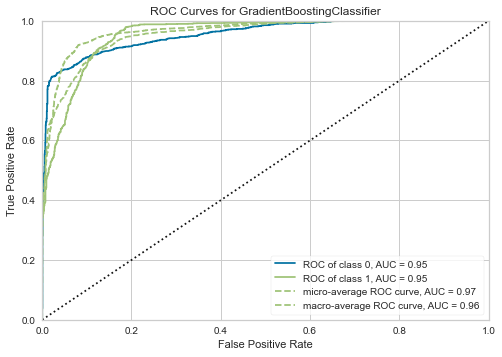

In [123]:
#roc and auc
plot_model(tuned_model,plot='auc')

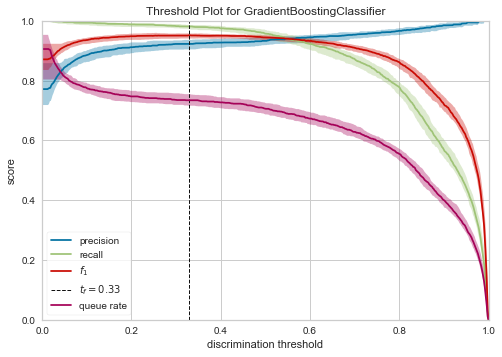

In [124]:
#Discrimination threshold
plot_model(tuned_model,plot='threshold')

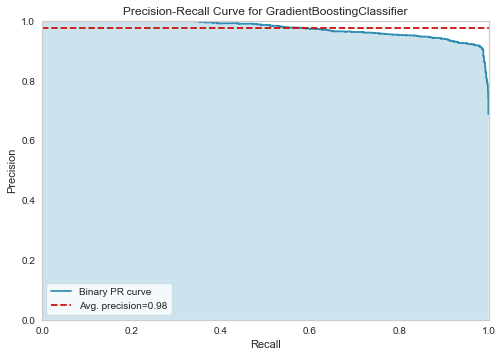

In [125]:
#Precision recall curve
plot_model(tuned_model,plot='pr')

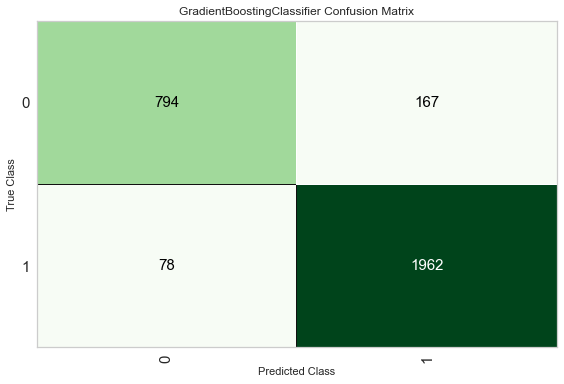

In [126]:

plot_model(tuned_model,plot='confusion_matrix')

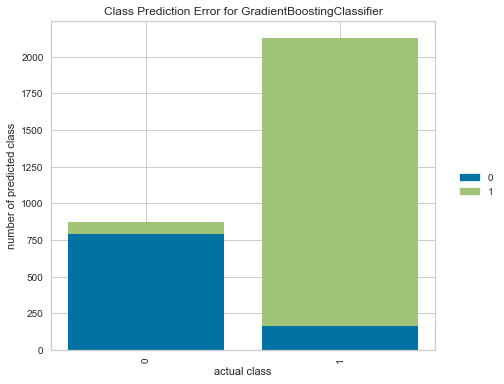

In [127]:
#Prediction error plot
plot_model(tuned_model,plot='error')

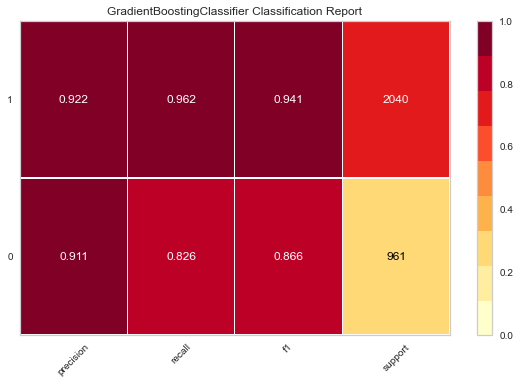

In [128]:
#class report
plot_model(tuned_model,plot='class_report')

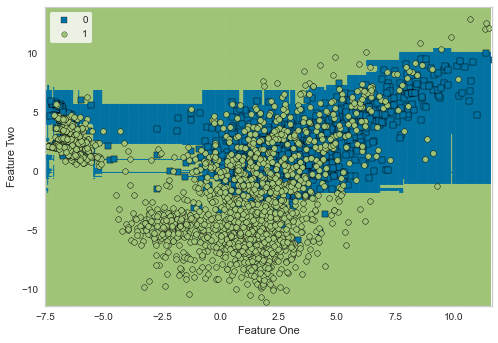

In [129]:
#boundary plot
plot_model(tuned_model,plot='boundary')

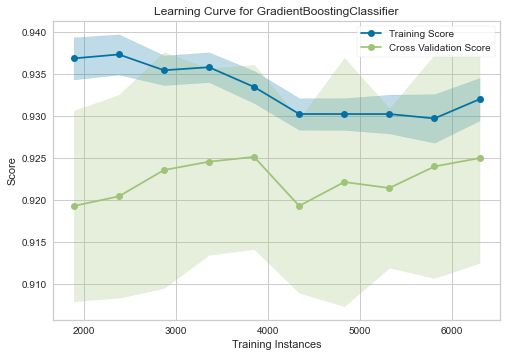

In [131]:
plot_model(tuned_model,plot='learning')

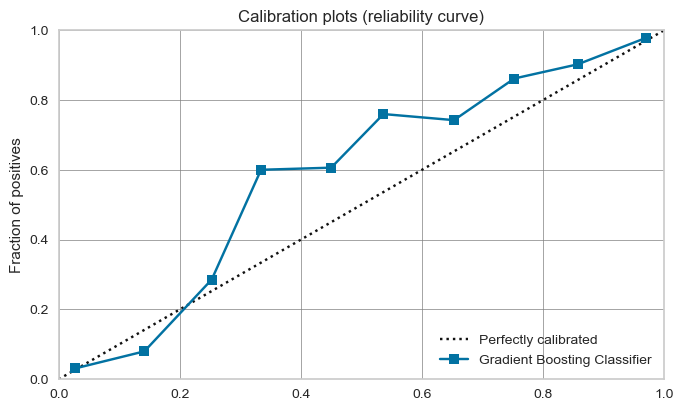

In [132]:
plot_model(tuned_model,plot='calibration')

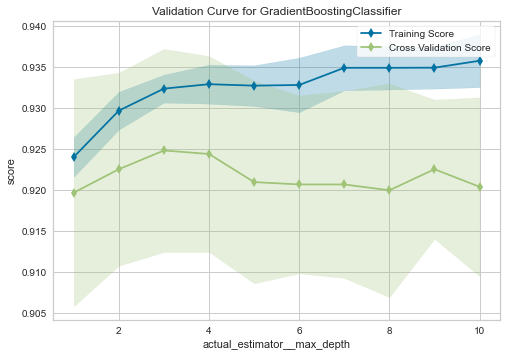

In [133]:
plot_model(tuned_model,plot='vc')

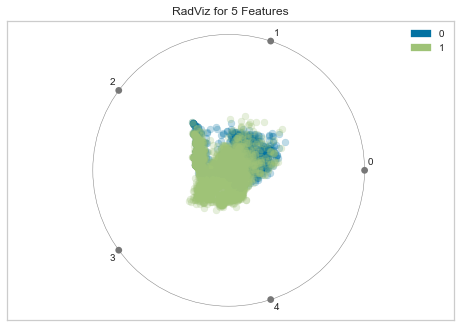

In [134]:
plot_model(tuned_model,plot='dimension')

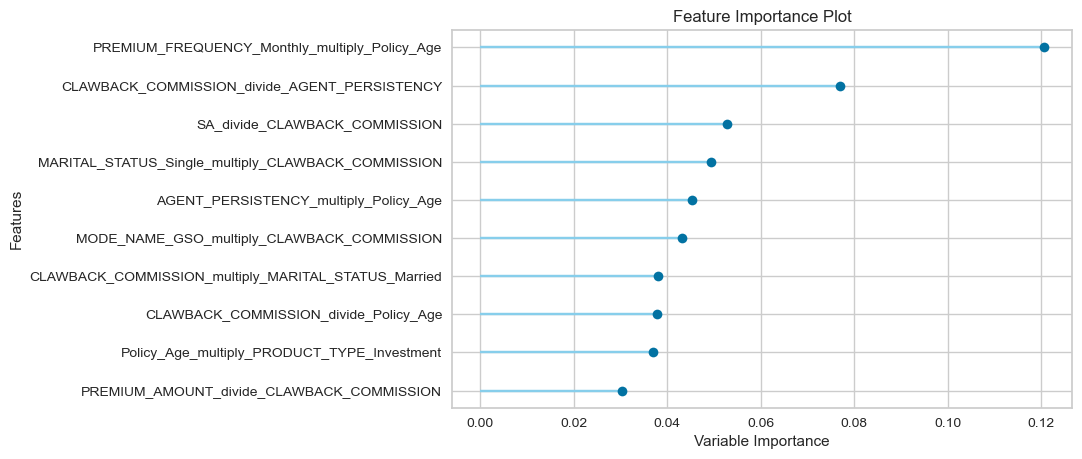

In [135]:
plot_model(tuned_model,plot='feature')

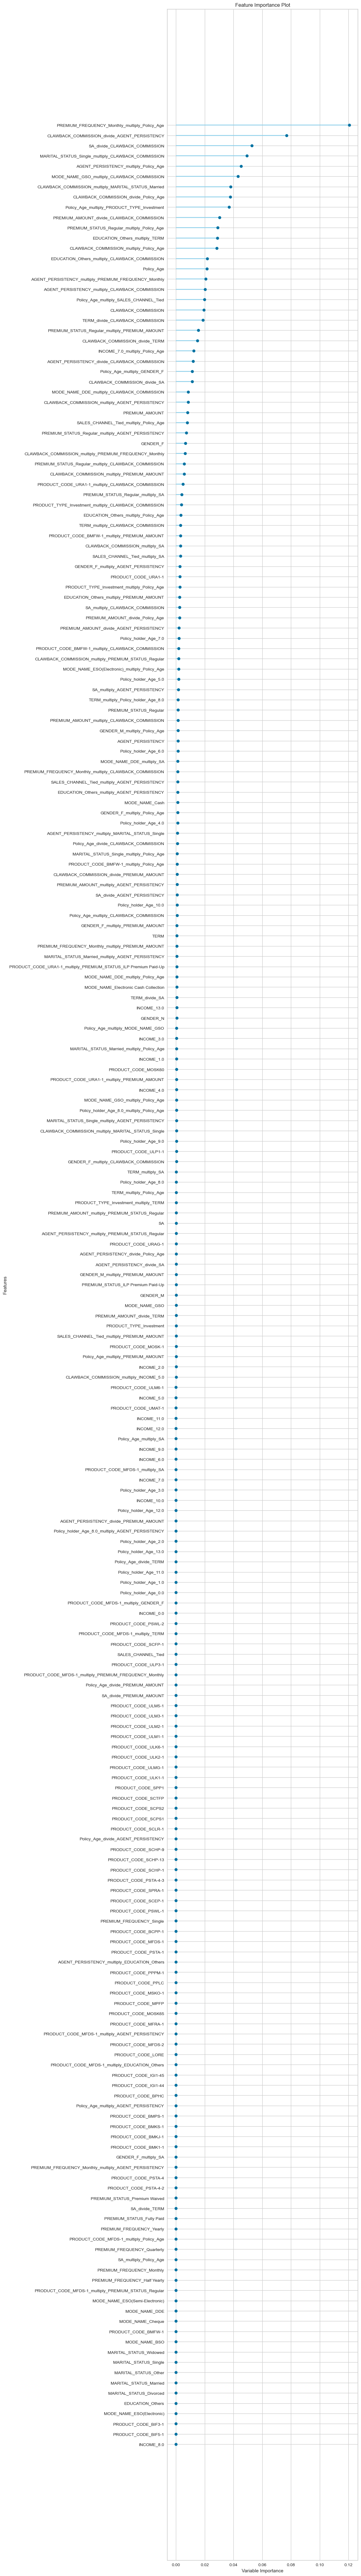

In [144]:
plot_model(tuned_model,plot='feature_all')

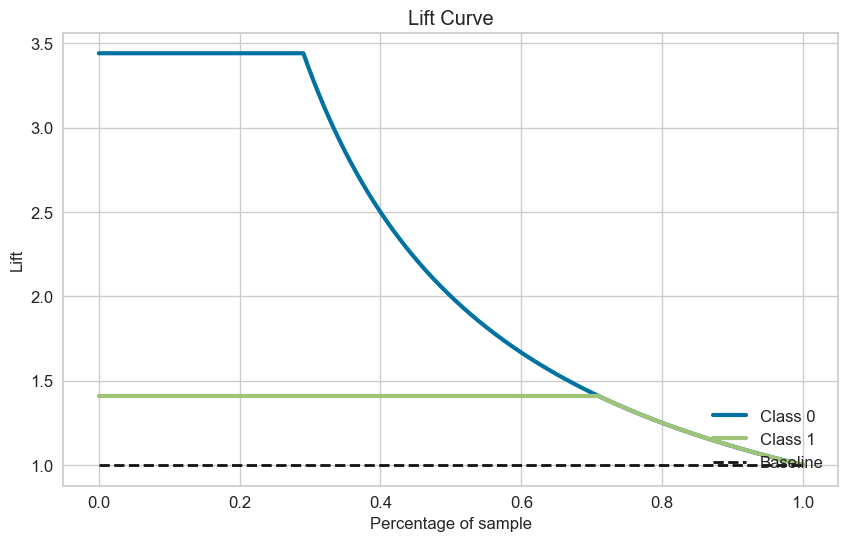

In [136]:
plot_model(tuned_model,plot='lift')

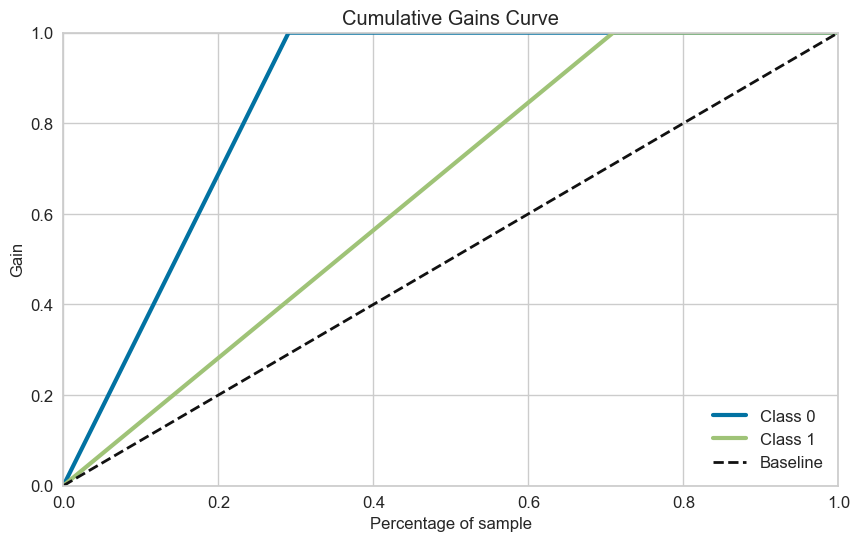

In [137]:
plot_model(tuned_model,plot='gain')

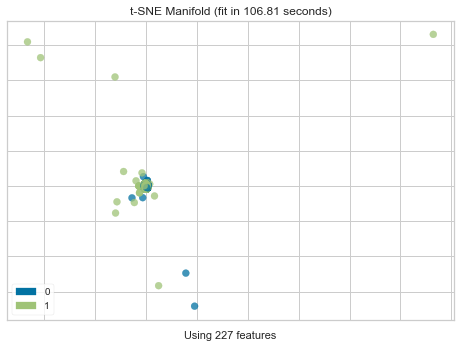

In [143]:
plot_model(tuned_model,plot='manifold')

# Bag Model

In [145]:
bagged_gbt = ensemble_model(tuned_model)